## 0. Load Packages

In [118]:
# Standard library imports
import os

# Data handling
import numpy as np
import pandas as pd

# Image processing
import cv2

# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input, SimpleRNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


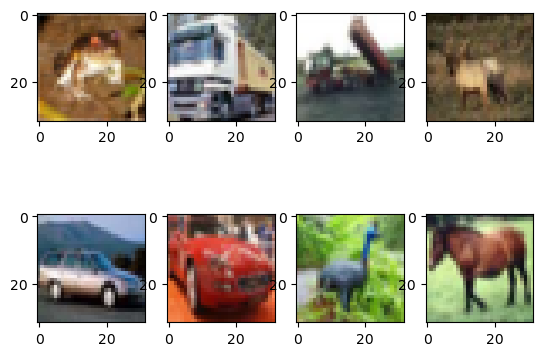

In [3]:
# [DO NOT MODIFY THIS CELL]
# Add labels
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [56]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2 Model I - CNN Neural networks

In [7]:
nn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
nn_model.summary()


/Users/jacksonzhao/miniconda3/envs/5243_proj3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,826 (1.99 MB)

 Trainable params: 521,866 (1.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Only do a model training based on the first 10000 imgs with cleaned label (8000-2000)
from sklearn.model_selection import train_test_split
import numpy as np

# n_train_img = 10000
n_train_img = 50000
target_vec = np.empty(n_train_img)
i = 0

for i in range(n_train_img):

    # target_vec[i] = clean_labels[i]
    target_vec[i] = noisy_labels[i]


feature = imgs[:n_train_img]



In [10]:
# resized_images = np.array([cv2.resize(img, (32, 32)) for img in feature_mtx])
# target_vec = to_categorical(target_vec, num_classes=10)


In [11]:
target_vec

array([3., 5., 9., ..., 9., 1., 1.])

Epoch 1/3
   4/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.0814 - loss: 4.2359

/Users/jacksonzhao/miniconda3/envs/5243_proj3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 34ms/step - accuracy: 0.1071 - loss: 2.4179 - val_accuracy: 0.1010 - val_loss: 2.3025
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.0991 - loss: 2.3030 - val_accuracy: 0.1145 - val_loss: 44.4354
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.1198 - loss: 2.2931 - val_accuracy: 0.1189 - val_loss: 6.2556


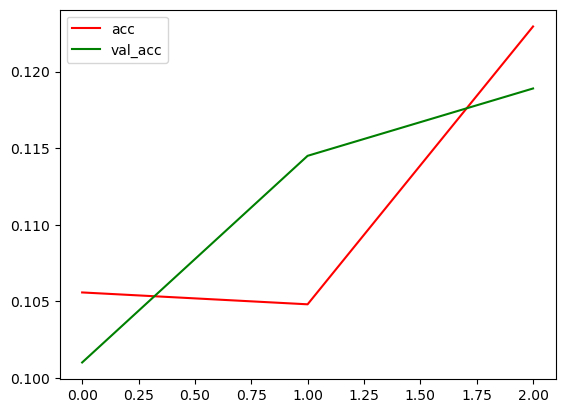

In [12]:
X_train, X_test, y_train, y_test = train_test_split(feature, target_vec, test_size=0.2, random_state=128)
X_train = X_train / 255.0

datagen = ImageDataGenerator(
    rotation_range=20,       # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    zoom_range=0.2,          # randomly zoom images
)

datagen.fit(X_train)

# earlystop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     verbose=1,
#     restore_best_weights=True
# )
h_callback = nn_model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                                    validation_data=(X_test, y_test),
                                    epochs=30)
                                    # callbacks=[earlystop])

plt.plot(h_callback.history['accuracy'], label='acc', color='red') 
plt.plot(h_callback.history['val_accuracy'], label='val_acc', color='green') 
plt.legend()

In [14]:
# Clean session
tf.keras.backend.clear_session()

#### 2.3 Model I - XGBoost

In [16]:
# # [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]
# no_bins = 6
# bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
# n_train_img = 50000
# target_vec = np.empty(n_train_img)
# feature_mtx = np.empty((n_train_img,3*(len(bins)-1)))
# i = 0

# for i in range(n_train_img):
#     # The target vector consists of noisy labels
#     target_vec[i] = noisy_labels[i]
    
#     # Use the numbers of pixels in each bin for all three channels as the features
#     feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
#     feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
#     feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
#     # Concatenate three features
#     feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
#     i += 1
    
# from xgboost import XGBClassifier
# xgb = XGBClassifier(
#     learning_rate=0.1,
#     n_estimators=500,
#     objective='multi:softmax', num_class=10)

# model1 = xgb.fit(X_train, y_train)

# # write your code here...


In [17]:
# from sklearn.metrics import accuracy_score
# y_pred = model1.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

In [19]:
# def model_I(image):
#     '''
#     This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
#     '''
#     feature1 = np.histogram(image[:,:,0],bins=bins)[0]
#     feature2 = np.histogram(image[:,:,1],bins=bins)[0]
#     feature3 = np.histogram(image[:,:,2],bins=bins)[0]
#     feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
#     return xgb.predict(feature)
#     #write your code here...

#### 2.4. Model II Random Forest

In [50]:
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators=500, random_state=42)
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

Accuracy: 0.324


In [20]:
# # [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# # write your code here...

# def model_II(image):
#     '''
#     This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
#     '''
#     # write your code here...

## 2.3 Model II

### 2.3.1 Feature Engineering
This step to prove the new features we added has improvement

Accuracy from 0.75 to 0.8 by baseline xgboost with only train/test using noisy labels

In [81]:
# Accuracy for Old Features
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
n_train_img = 50000
target_vec = np.empty(n_train_img)
feature_mtx = np.empty((n_train_img,3*(len(bins)-1)))
i = 0

for i in range(n_train_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1
    
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(feature_mtx, target_vec, test_size=0.2, random_state=128)


# Train Model
from xgboost import XGBClassifier
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=500,
    objective='multi:softmax', num_class=10)

xgb_m = xgb.fit(feature_mtx, target_vec)

# Predict
y_pred = xgb_m.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7492


In [82]:
# Accuracy by new features
# Initiate Value
n_train_img = 50000
target_vec = np.empty(n_train_img)
feature_mtx = np.empty((n_train_img,5*(len(bins)-1)))
i = 0

# Feature engineering
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
for i in range(n_train_img):

    target_vec[i] = noisy_labels[i]
    
    # Existing histogram features
    feature1 = np.histogram(imgs[i][:,:,0], bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1], bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2], bins=bins)[0]
    
    # Calculate mean, std, skewness for each channel
    color_features = []
    for channel in range(3):
        channel_data = imgs[i][:,:,channel]
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        skewness = skew(channel_data, axis=None)
        color_features.extend([mean, std, skewness])
    
    # Example for edge detection feature - Sobel magnitude (simplified)
    sx = sobel(imgs[i][:,:,0], axis=0, mode='constant')
    sy = sobel(imgs[i][:,:,0], axis=1, mode='constant')
    sobel_magnitude = np.sqrt(sx**2 + sy**2).mean()  # Using mean of gradient magnitude as a feature
    
    # Concatenate all features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3, color_features, [sobel_magnitude]), axis=None)
    
    i += 1

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(feature_mtx, target_vec, test_size=0.2, random_state=128)


# Train Model
from xgboost import XGBClassifier
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=500,
    objective='multi:softmax', num_class=10)

xgb_m = xgb.fit(feature_mtx, target_vec)

# Predict
y_pred = xgb_m.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8062


### 2.3.2 Generate 50000 labels better than noisy labels using 10000 labels (noisy and clean)

#### 2.3.2.1 Generate Features
Also add noisy label as one of the predictors

In [109]:
n_train_img = 10000
noisy_y = np.empty(n_train_img)
clean_y = np.empty(n_train_img)
feature_mtx = np.empty((n_train_img,26))
i = 0

for i in range(n_train_img):

    noisy_y[i] = noisy_labels[i]
    clean_y[i] = clean_labels[i]
    
    # Existing histogram features
    feature1 = np.histogram(imgs[i][:,:,0], bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1], bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2], bins=bins)[0]
    
    # Calculate mean, std, skewness for each channel
    color_features = []
    for channel in range(3):
        channel_data = imgs[i][:,:,channel]
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        skewness = skew(channel_data, axis=None)
        color_features.extend([mean, std, skewness])
    
    # Example for edge detection feature - Sobel magnitude (simplified)
    sx = sobel(imgs[i][:,:,0], axis=0, mode='constant')
    sy = sobel(imgs[i][:,:,0], axis=1, mode='constant')
    sobel_magnitude = np.sqrt(sx**2 + sy**2).mean()  # Using mean of gradient magnitude as a feature
    
    # Concatenate all features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3, color_features, [sobel_magnitude], [noisy_labels[i]]), axis=None)
    
    i += 1

#### 2.3.2.2 Model Selection

XGBoost is the best

In [110]:
# Assuming 'feature_mtx', 'clean_y' are already defined
X_train, X_val, y_train, y_val = train_test_split(feature_mtx, clean_y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Model dictionary for traditional ML models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
}

# Train and evaluate each traditional ML model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{name} Accuracy: {accuracy}")

# Neural Network
model_nn = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(clean_y)), activation='softmax')
])

model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_nn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=2)
loss, accuracy_nn = model_nn.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Neural Network Accuracy: {accuracy_nn}")

# Simplified CNN Example
model_cnn = Sequential([
    Input(shape=(X_train_scaled.shape[1], 1)),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(clean_y)), activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1), y_train, epochs=10, batch_size=32, verbose=2)
accuracy_cnn = model_cnn.evaluate(X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1), y_val, verbose=0)[1]
print(f"CNN Accuracy: {accuracy_cnn}")

# Simplified RNN Example
model_rnn = Sequential([
    Input(shape=(X_train_scaled.shape[1], 1)),
    SimpleRNN(64),
    Dense(len(np.unique(clean_y)), activation='softmax')
])

model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_rnn.fit(X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1), y_train, epochs=10, batch_size=32, verbose=2)
accuracy_rnn = model_rnn.evaluate(X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1), y_val, verbose=0)[1]
print(f"RNN Accuracy: {accuracy_rnn}")

# Generate and print classification report for each model
predictions = []
# Collect predictions from traditional ML models
for name, model in models.items():
    y_pred = model.predict(X_val_scaled)
    predictions.append((name, y_pred))

# Neural Network prediction
y_pred_nn = model_nn.predict(X_val_scaled)
y_pred_nn = np.argmax(y_pred_nn, axis=1)  # Convert probabilities to class labels
predictions.append(("Neural Network", y_pred_nn))

# CNN prediction
y_pred_cnn = model_cnn.predict(X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1))
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
predictions.append(("CNN", y_pred_cnn))

# RNN prediction
y_pred_rnn = model_rnn.predict(X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1))
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
predictions.append(("RNN", y_pred_rnn))

# Print classification reports
for name, y_pred in predictions:
    print(f"Classification Report for {name}:")
    print(classification_report(y_val, y_pred))
    print("\n" + "="*60 + "\n")

/Users/jacksonzhao/miniconda3/envs/5243_proj3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Random Forest Accuracy: 0.417
XGBoost Accuracy: 0.4515
Logistic Regression Accuracy: 0.382
KNN Accuracy: 0.3075
SVM Accuracy: 0.402
Epoch 1/10
250/250 - 0s - 1ms/step - accuracy: 0.2761 - loss: 1.9933
Epoch 2/10
250/250 - 0s - 396us/step - accuracy: 0.3471 - loss: 1.7999
Epoch 3/10
250/250 - 0s - 393us/step - accuracy: 0.3762 - loss: 1.7461
Epoch 4/10
250/250 - 0s - 398us/step - accuracy: 0.3855 - loss: 1.7125
Epoch 5/10
250/250 - 0s - 403us/step - accuracy: 0.3949 - loss: 1.6829
Epoch 6/10
250/250 - 0s - 497us/step - accuracy: 0.4080 - loss: 1.6604
Epoch 7/10
250/250 - 0s - 396us/step - accuracy: 0.4139 - loss: 1.6407
Epoch 8/10
250/250 - 0s - 403us/step - accuracy: 0.4206 - loss: 1.6202
Epoch 9/10
250/250 - 0s - 403us/step - accuracy: 0.4241 - loss: 1.6064
Epoch 10/10
250/250 - 0s - 397us/step - accuracy: 0.4321 - loss: 1.5917
Neural Network Accuracy: 0.4025000035762787
Epoch 1/10
250/250 - 0s - 2ms/step - accuracy: 0.2755 - loss: 1.9873
Epoch 2/10
250/250 - 0s - 892us/step - accurac

#### 2.3.2.3 Tune Parameter
80% clean label to train model (10 C-V), using 20% to validate, calculating accuracy.

Then using the best model to generate labels for the rest 40000 images 

In [117]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(feature_mtx, clean_y, test_size=0.2, random_state=42)

# Define the parameter space for Randomized Search
param_dist = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.3, 0.5, 0.7],
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'min_child_weight': [1, 5, 10]
}

# Initialize the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Setup RandomizedSearchCV with verbose output
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=3, scoring='accuracy', n_jobs=-1, cv=10, random_state=42, verbose=3)

# Fit the RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters found: ", random_search.best_params_)

# Use the best estimator to make predictions on the validation set and the entire dataset
y_pred_val = random_search.best_estimator_.predict(X_val)
y_pred_full = random_search.best_estimator_.predict(feature_mtx)

# Calculate and print accuracies
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_full_clean = accuracy_score(clean_y, y_pred_full)
accuracy_full_noisy = accuracy_score(noisy_y, y_pred_full)
print(f"Validation Accuracy: {accuracy_val}")
print(f"Full Dataset Accuracy (vs Clean Labels): {accuracy_full_clean}")
print(f"Full Dataset Accuracy (vs Noisy Labels): {accuracy_full_noisy}")

# Calculate and print precision and recall for the validation set
precision_val = precision_score(y_val, y_pred_val, average='macro')
recall_val = recall_score(y_val, y_pred_val, average='macro')
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")

# Feature importance from the best model
feature_importances = random_search.best_estimator_.feature_importances_
print("Feature Importances: ", feature_importances)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


/Users/jacksonzhao/miniconda3/envs/5243_proj3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/jacksonzhao/miniconda3/envs/5243_proj3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best Parameters found:  {'subsample': 0.3, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Validation Accuracy: 0.462
Full Dataset Accuracy (vs Clean Labels): 0.6618
Full Dataset Accuracy (vs Noisy Labels): 0.5336
Validation Precision: 0.45859292920347466
Validation Recall: 0.4595138538528672
Feature Importances:  [0.03410105 0.03282854 0.0328377  0.03302653 0.03294383 0.03583854
 0.03300237 0.03185454 0.03260883 0.03345367 0.0343002  0.0393818
 0.03365973 0.04022283 0.0471343  0.033983   0.03494786 0.03363161
 0.03594596 0.03693751 0.03504769 0.04157996 0.04029515 0.040047
 0.0431895  0.09720024]
[CV 8/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=500, subsample=0.3;, score=0.487 total time=  15.9s
[CV 5/10] END colsample_bytree=0.75, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.3;, score=0.403 total time=  36.3s
[CV 1/10] END colsample_byt

In [131]:
print("Best model type:", type(random_search.best_estimator_))
print("Best parameters found:", random_search.best_params_)

Best model type: <class 'xgboost.sklearn.XGBClassifier'>
Best parameters found: {'subsample': 0.3, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


#### 2.3.2.4 Save Best Model

In [123]:
import joblib

# Assuming the rest of your code is unchanged and comes before this:

# Save the best model
best_model = random_search.best_estimator_
joblib.dump(best_model, '../best_xgboost_model.pkl')

print("Best model saved as 'best_xgboost_model.pkl'")

Best model saved as 'best_xgboost_model.pkl'


#### 2.3.2.5 Load Best Model

In [132]:
import pickle
import xgboost as xgb

# Assuming you have your trained model 'best_model'
with open('../best_xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
with open('../best_xgboost_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

In [133]:
# Print hyperparameters of the model
print("Model Hyperparameters:")
print(best_model.get_params())
# Print feature importances
print("Feature Importances:")
print(best_model.feature_importances_)
# Dump model
print("Model Dump:")
dump_list = best_model.get_booster().get_dump()
for tree in dump_list[:2]:  # Just print the first two trees
    print(tree)


Model Hyperparameters:
{'objective': 'multi:softprob', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 10, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.3, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Feature Importances:
[0.03410105 0.03282854 0.0328377  0.03

## 4.1 XGBoost + Random Forest

In [65]:
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
n_train_img = 50000
target_vec = np.empty(n_train_img)
feature_mtx = np.empty((n_train_img,3*(len(bins)-1)))
i = 0

for i in range(n_train_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1
    
from xgboost import XGBClassifier
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=500,
    objective='multi:softmax', num_class=10)

xgb_m = xgb.fit(feature_mtx, target_vec)

In [66]:
def xgb_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return xgb_m.predict(feature)

In [67]:
input = []
for i in range(10000):
    input.append(xgb_model(imgs[i]))

input = np.array(input).astype(np.float64)

output = clean_labels

Accuracy: 0.095


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=128)
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

## 4.2 Random Forest + XGBoost

In [25]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf_m = rf.fit(feature_mtx, target_vec)

In [26]:
def rf_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return rf_m.predict(feature)

In [27]:
input = []
for i in range(10000):
    input.append(rf_model(imgs[i]))

input = np.array(input).astype(np.float64)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=128)
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=500,
    objective='multi:softmax', num_class=10)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4005


## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [30]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [32]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

FileNotFoundError: ../data/data/test_labels.csv not found.

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.